# Implement a convolutional neural network to recognize hand-written digits

#**3**
**3A**
Explain the working of each type of layer in a CNN

1. Convolution Layer
It applies set of filters  to the input.
Each filter or Kernel convolvs across the width and height of the input calculating the dot product between the filter and input. It produces a 2D map for each filter and captures local dependencies in the input.

It has filter and stride size as hyper parameters:
Filter size determines the dimension of the kernel. Common choices are 3x3 or 5x5.
Stride size dictates the step length the filter moves across the input. A stride of 1 moves the filter one pixel at a time.

2. Activation Layer
This layer transforms the output of convolution layer using some activation function such as RELU to introduce non linearity in the network.

3. Pooling Layer
This layer reduces the spatial size of the input volume from the convolution layer, this also makes the network less sensetive to the location size of the feature.
Common pooling operations include max pooling or average pooling where either max or average of the group of pixels are taken respectively.
Pooling is applied to each slice of the input and resizes it spatially.

4. Fully Connected Layer
Fully connected layer computes the class scores resulting in the volume size equal to the number of classes in the classification problem. Each neuron in a fully connected layer is connected to every other neuron in the previous layer.
Fully connected layers are used towards the end of a CNN to classify the input to a label. This layer take the features learned by the previous layers and use them to classify an image as it takes the high dimensional output from previous convolution and pooling layers and flattens it into one dimensional vector combining all the extracted features across the image rather than focusing on the local features. This layer helps in understanding th eglobal context of the image.

5. Output Layer:
This layer transforms the input from the Fully connected layer to a probablities. for classification problem this layer can use softmax function which converts the logits into probablities where all the probablities sum up to 1 providing the class probablities.


Examples of CNN Architectures are :
LeNet-5: it is of the earliest CNNs which included two sets of convolution and average pooling layers, followed by fully connected layers. It was used to recognize hand written and machine printed characters.

AlexNet: It is a complex CNN which consists of 5 convolutional layers, some of which are followed by max-pooling layers, and 3 fully connected layers at the end. It was used for large scale image recognition task.

VGGNet: Known for its simplicity with a series of convolutional layers with small filters (3x3) followed by max-pooling layers and ending with three fully connected layers. It is also used for large scale image recognition.

ResNet: It introduced the concept of skiping connections to enable training of very deep networks. It is also used for large scale image recognition

GoogLeNet (Inception Network): Characterized by its inception modules, which use parallel convolutions . It is also used for large scale image recognition

In [1]:
import math

# Setup
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 12345
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

## Get MNIST Data
The `torchvision` package provides a wrapper to download MNIST data. The cell below downloads the training and test datasets and creates dataloaders for each.

In [4]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
#train_data.data are of type uint8 (range 0,255) so divide by 255.
# train_mean = train_data.data.double().mean() / 255.
# train_std = train_data.data.double().std() / 255.
# # print(f'Train Data: Mean={train_mean}, Std={train_std}')
#
# # Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# #This will convert data to be approximately standard normal
# transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((train_mean, ), (train_std, ))
# ])
#
# train_data.transform = transform
# test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

## Part 0: Inspect dataset

## Part 1: Implement a convolutional neural network

Write a class that constructs a two-layer neural network as specified in the handout. The class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        # ------------------
        # Write your implementation here.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0) # first convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=0)
        self.relu_activation_function = nn.ReLU()
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        # second convolutional layer
        self.fc = nn.Linear(in_features=20 * 4 * 4, out_features=10) # third fully-connected layer
        # ------------------
    
    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1


        x = self.pooling_layer(self.relu_activation_function(self.conv1(x)))
        x = self.pooling_layer(self.relu_activation_function(self.conv2(x)))
        x = self.flatten(x)

        x = self.relu_activation_function(x)
        x = self.fc(x)
        y_output = F.log_softmax(x, dim=1)

        # ------------------
        # Write your implementation here.        


        
        return y_output
        # ------------------

model = CNN()
model.to(DEVICE)

# sanity check
print(model)

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu_activation_function): ReLU()
  (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)


Write a method called `train_one_epoch` that runs one step using the optimizer.

In [50]:

def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    train_loss_per_epoch = 0
    num_correct = 0

    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        output = model(img)
        optimizer.zero_grad()
        loss = F.nll_loss(output, label)
        train_loss_per_epoch += loss.item()
        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        num_correct += pred.eq(label.view_as(pred)).sum().item()




        # ------------------
        # Copy the implementation from Problem 4 here
        
               
        # ------------------
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter, train_loss_per_epoch/len(train_loader), num_correct

Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [51]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            output = model(img)

            # Calculate the negative log likelihood loss
            loss = F.nll_loss(output, label, reduction='sum')
            test_loss += loss.item()

            # Get the predicted label
            pred = output.argmax(dim=1, keepdim=True)

            # Count the number of correct predictions
            num_correct += pred.eq(label.view_as(pred)).sum().item()

            # ------------------
            # Copy the implementation from Problem 4 here

            # ------------------
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

Train the model using the cell below. Hyperparameters are given.

In [52]:
from tqdm import tqdm
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_accuracy = []
test_accuracy = []
train_counter = []
test_losses = []
train_loss_per_epoch = []
test_correct = []
train_correct = []

pbar = tqdm(range(max_epochs), desc="Epoch")
for epoch in range(max_epochs):
    train_loss, counter, train_loss_per_one_epoch, num_correct_train = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)
    train_correct.append(num_correct_train)
    train_loss_per_epoch.append(train_loss_per_one_epoch)
    test_accuracy.append((num_correct/len(test_loader.dataset)) * 100)
    train_accuracy.append((num_correct_train/len(train_loader.dataset)) * 100)

    pbar.set_postfix(dict={'current_accuracy_test' : (num_correct/len(test_loader.dataset)) * 100 , 'current_accuracy_train' : ((num_correct_train/len(train_loader.dataset)) * 100)}, refresh=True)
    pbar.update(1)
    #print(f"Test accuracy at epoch {epoch+1}: {(num_correct/len(test_loader.dataset)) * 100}% ", end='\r', flush=True)


print(f"Test accuracy Final: {test_correct[-1]/len(test_loader.dataset)}")


Epoch: 100%|██████████| 10/10 [54:13<00:00, 325.38s/it, dict={'current_accuracy_test': 98.55000000000001, 'current_accuracy_train': 98.53833333333334}]

Epoch: 100%|██████████| 10/10 [04:17<00:00, 24.37s/it, dict={'current_accuracy_test': 98.55000000000001, 'current_accuracy_train': 98.53166666666667}]

Test accuracy Final: 0.9855


In [53]:
train_loss_per_epoch_r = list(map(lambda x : round(x,5), train_loss_per_epoch))
test_losses_r = list(map(lambda x : round(x,5), test_losses))
train_accuracy_r = list(map(lambda x : round(x,5), train_accuracy))
test_accuracy_r = list(map(lambda x : round(x,5), test_accuracy))


In [1]:
print("Stats for CNN with ReLU activation Function")

NameError: name 'train_loss_per_epoch' is not defined

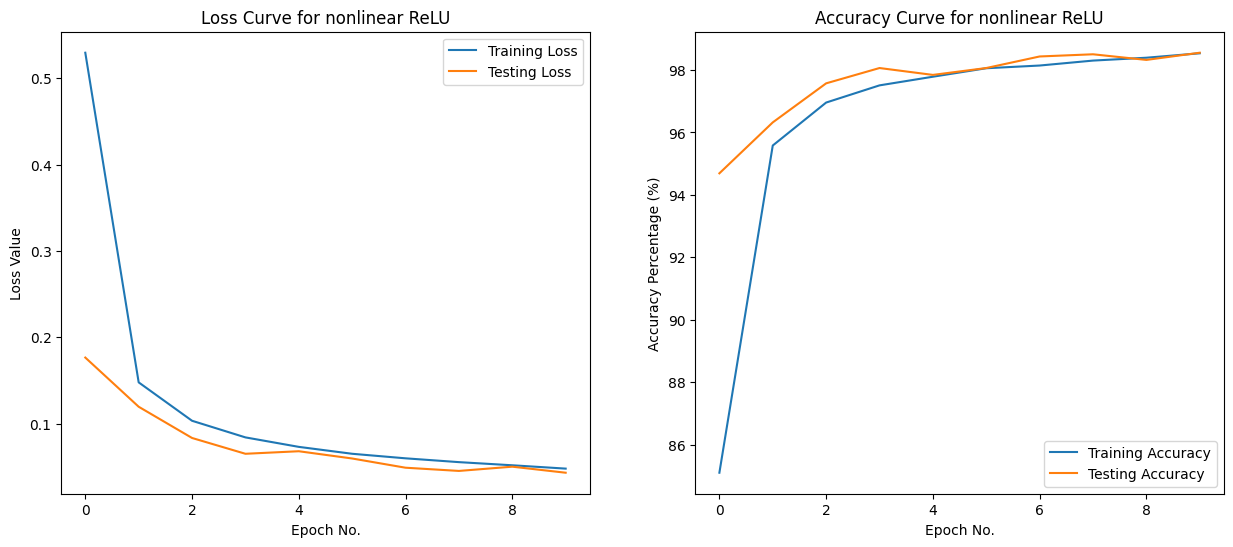

In [54]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 6))

# Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_per_epoch_r, label='Training Loss')
plt.plot(test_losses_r, label='Testing Loss')
plt.title('Loss Curve for nonlinear ReLU')
plt.xlabel('Epoch No.')
plt.ylabel('Loss Value')
plt.legend()

# Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_r, label='Training Accuracy')
plt.plot(test_accuracy_r, label='Testing Accuracy')
plt.title('Accuracy Curve for nonlinear ReLU')
plt.xlabel('Epoch No.')
plt.ylabel('Accuracy Percentage (%)')
plt.legend()

plt.show()


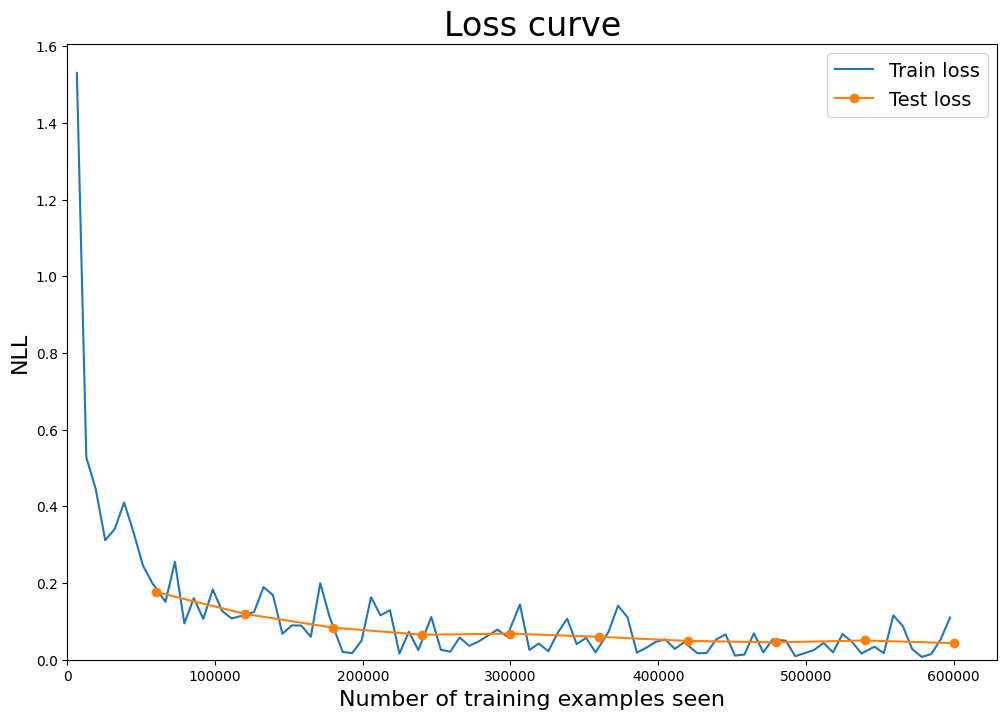

In [55]:
# 1. Draw training loss curve
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)],
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

In [56]:
# 3. Get 20 incorrect predictions in test dataset

# Collect the images, predictions, labels for the first 20 incorrect predictions
# Initialize empty tensors and then keep appending to the tensor.
# Make sure that the first dimension of the tensors is the total number of incorrect
# predictions seen so far
# Ex) incorrect_imgs should be of shape i x C x H x W, where i is the total number of
# incorrect images so far.
incorrect_imgs = torch.Tensor().to(DEVICE)
incorrect_preds = torch.IntTensor().to(DEVICE)
incorrect_labels = torch.IntTensor().to(DEVICE)

with torch.no_grad():
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        output = model(images)

        # Get predictions
        pred = output.argmax(dim=1)


        # Find indices where predictions and labels don't match (incorrect predictions)
        incorrect_indices = torch.nonzero(pred != labels).squeeze()





        # Append incorrect predictions to tensors using torch.cat
        if incorrect_indices.numel() > 0:
            if incorrect_indices.numel() == 1 :
                incorrect_indices = incorrect_indices.unsqueeze(0)

            incorrect_imgs = torch.cat((incorrect_imgs, images[incorrect_indices]), dim=0)

            incorrect_preds = torch.cat((incorrect_preds, pred[incorrect_indices]), dim=0)
            incorrect_labels = torch.cat((incorrect_labels, labels[incorrect_indices]), dim=0)


        # Break the loop if we have collected at least 20 incorrect predictions
        if incorrect_imgs.size(0) >= 20:
            break




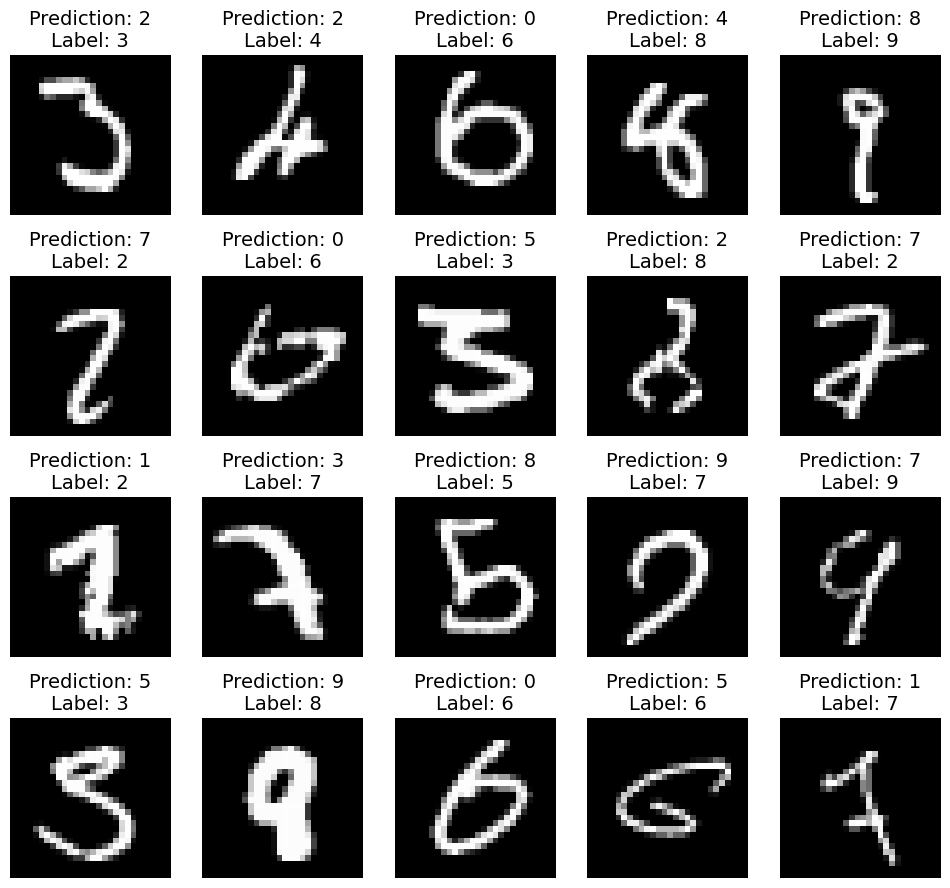

In [57]:

# Show the first 20 wrong predictions in test set
fig = plt.figure(figsize=(12, 11))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {incorrect_preds[i].item()}\nLabel: {incorrect_labels[i].item()}', fontsize=14)
    plt.axis('off')

In [1]:
import getpass

# Prompt the user for a password
password = getpass.getpass("Enter your password: ")

# Now 'password' contains the entered password, and it won't be echoed to the console
print("Password entered:", password)


Password entered: bch
